<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Redes Neuronales Recurrentes (RNN) y Series Temporales</h1> </div>

Desarrollado por: Ing. Remigio Hurtado Ortiz, PhD. Correo de contacto: remihuro@hotmail.com

Predicción de la contaminación en la hora actual (t) dada la medición de la contaminación y las condiciones climáticas en el paso de tiempo anterior.

Esta práctica está estructurada de la siguiente manera:

- [Preparación de datos](#Preparacion)
- [Desarrollo de RNN](#RNN)
- [Conclusiones](#Conclusiones)
- [Referencias](#Referencias)

<div id="Fundamentos" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Preparación de datos</h2> </div>

In [7]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')
dataset.head()

#Descripción:
#Cada fila es el registro de una hora
#La variable de salida Y, es pollution (contaminación)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [34]:
print(dataset.shape)#Cantidad de horas -> registros
print(int(dataset.shape[0])/24)#Cantidad de días
print((int(dataset.shape[0])/24)/365)#Cantidad de años
print(365*24)#Cantidad de registros por año

(43800, 8)
1825.0
5.0
8760


#### ANÁLISIS EXPLORATORIO

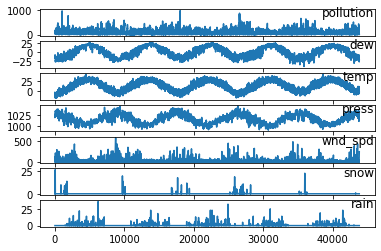

In [3]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
#La variable wnd_dir es categórica y contiene texto, se debe transformar.
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE FUNCIONES PROPIAS

In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
print('Módulos importados')
 
# convert series to supervised learning
# Se combina varias filas en una sola
#n_in: las filas de la secuencia (t-n, ... t-1)
#n_out: las filas de la secuencia (t, t+1, ... t+n)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Módulos importados


#### CARGA DE DATASET Y TRANSFORMACIÓN (NORMALIZACIÓN)

In [2]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
#La variable wnd_dir es categórica ordinal. Realizamos la transformación.
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.12977867 0.35294122 0.24590163 ... 0.00229001 0.         0.        ]
 [0.14889336 0.36764708 0.24590163 ... 0.00381099 0.         0.        ]
 [0.15995975 0.4264706  0.22950819 ... 0.00533197 0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]
 [0.01207243 0.2794118  0.26229507 ... 0.42621556 0.         0.        ]]


In [3]:
print(scaled.shape)
scaled[:,-8]

(43800, 8)


array([0.12977867, 0.14889336, 0.15995975, ..., 0.01006036, 0.00804829,
       0.01207243], dtype=float32)

In [4]:
# frame as supervised learning
# En primer lugar, tomaremos fila a fila. Es decir, no combinaremos. El aprendizaje será día por día
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [5]:
values=reframed.values
values[:,-8]

array([0.14889336, 0.15995975, 0.18209255, ..., 0.01006036, 0.00804829,
       0.01207243], dtype=float32)

In [6]:
# drop: eliminamos columnas que no deseamos predecir
#Variable a predecir es pollution. Es decir, var1(t)
#var1(t-1) es la contaminación de la hora anterior
#var1(t) es la contaminación a predecir
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


<div id="RNN" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Desarrollo de la RNN</h2> </div>

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 13s - loss: 0.0537 - val_loss: 0.0693 - 13s/epoch - 103ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0362 - val_loss: 0.0717 - 2s/epoch - 17ms/step
Epoch 3/50
122/122 - 3s - loss: 0.0219 - val_loss: 0.0594 - 3s/epoch - 22ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0173 - val_loss: 0.0463 - 2s/epoch - 16ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0159 - val_loss: 0.0330 - 2s/epoch - 15ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0153 - val_loss: 0.0244 - 2s/epoch - 18ms/step
Epoch 7/50
122/122 - 3s - loss: 0.0151 - val_loss: 0.0223 - 3s/epoch - 23ms/step
Epoch 8/50
122/122 - 3s - loss: 0.0150 - val_loss: 0.0200 - 3s/epoch - 22ms/step
Epoch 9/50
122/122 - 3s - loss: 0.0149 - val_loss: 0.0180 - 3s/epoch - 26ms/step
Epoch 10/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0169 - 3s/epoch - 21ms/step
Epoch 11/50
122/122 - 3s - loss: 0.0148 - val_loss: 0.0163 - 3s/epoch - 22ms/step
Epoch 12/50
122/122 - 3s - loss: 0.0147 - val_loss: 0.0155 -

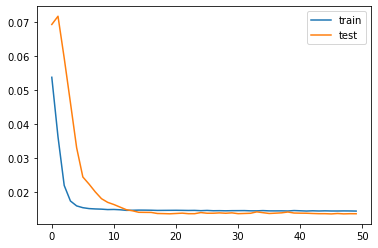

In [35]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 # Del primer año (365 días). Cada día tiene 24 horas. 8760 horas en total.
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
#y es la última columna, que es var1(t), la variable a predecir (la contaminación)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#timesteps=1, el paso del tiempo es de una hora
#Cada observación es una sola hora
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### PREDICCIONES Y EVALUACIÓN DEL MODELO

In [56]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
#el modelo alcanza un RMSE respetable de 26.496, que es menor que un RMSE de 30 encontrado 
#con un modelo de persistencia.

Test RMSE: 26.554


#### RNN CON UN TIEMPO DE 3 HORAS

(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 10s - loss: 0.0416 - val_loss: 0.0568
Epoch 2/50
122/122 - 3s - loss: 0.0237 - val_loss: 0.0316
Epoch 3/50
122/122 - 2s - loss: 0.0211 - val_loss: 0.0219
Epoch 4/50
122/122 - 2s - loss: 0.0207 - val_loss: 0.0202
Epoch 5/50
122/122 - 2s - loss: 0.0204 - val_loss: 0.0208
Epoch 6/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0191
Epoch 7/50
122/122 - 2s - loss: 0.0193 - val_loss: 0.0191
Epoch 8/50
122/122 - 2s - loss: 0.0188 - val_loss: 0.0184
Epoch 9/50
122/122 - 2s - loss: 0.0184 - val_loss: 0.0181
Epoch 10/50
122/122 - 2s - loss: 0.0179 - val_loss: 0.0176
Epoch 11/50
122/122 - 2s - loss: 0.0176 - val_loss: 0.0177
Epoch 12/50
122/122 - 2s - loss: 0.0170 - val_loss: 0.0180
Epoch 13/50
122/122 - 2s - loss: 0.0164 - val_loss: 0.0181
Epoch 14/50
122/122 - 2s - loss: 0.0160 - val_loss: 0.0183
Epoch 15/50
122/122 - 2s - loss: 0.0157 - val_loss: 0.0179
Epoch 16/50
122/122 - 2s - loss: 0.0154 - v

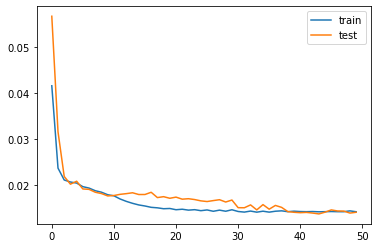

Test RMSE: 26.460


In [3]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
# Cada observación es la combinación de n_hours (3 horas)
n_hours = 3 
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]#1 año
test = values[n_train_hours:, :]#4 años

# split into input and outputs
n_obs = n_hours * n_features# 3*8=24 
# se selecciona para X las primeras n_obs, esdecir, las primeras 24
# para y se selecciona solamente la variable n_obs+1, que es "-n_features", es -8 en python, 
# sería la octava contando desde el final, esta es la variable pollution var1(t)
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D (samples, timesteps, features)
# Una red neuronal recurrente puede trabajar con estructuras de varias dimensiones
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

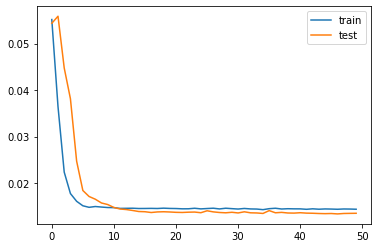

In [17]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
def prediccion():
    #Xnew = np.array([[-21,-3.0,1034.0,249.85,0,0]])#real es 12
    Xnew = np.array([[129.0,-16,-4.0,1020.0,'SE',1.79,0,0]])#real es 79
    Xnew[:,4] = encoder.transform(Xnew[:,4])
    # ensure all data is float
    Xnew = Xnew.astype('float32')
    Xnew= scaler.transform(Xnew)
    Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
    pred= model.predict(Xnew)[0]
    return pred

pred=prediccion()
print('Pollution: ',pred)

1/1 [==============================] - 0s 67ms/step
Pollution:  [0.12858711]


<div id="Conclusiones" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusiones</h2> </div>

En esta práctica has aprendido a realizar la exploración en un dataset de series de tiempo y has desarrollado una red neuronal recurrente para predicción de contaminación. 

<div id="Referencias" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Referencias</h2> </div>

[1] Bishop, C. M. (2006). Pattern recognition and machine learning. Springer.

[2] P. Joshi. (2017). Artificial intelligence with python. Packt Publishing Ltd.

**Enlaces de documentación de tensorflow y keras:**

https://keras.io/api/layers/recurrent_layers/lstm/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM